# Krypton selection

## Selection of events in terms of S1 and S2

### Specify run number and file range. 

If file range = ALL, all the kdsts in the directory will be analyzed

In [59]:
run_number  = 6206
file_range  = 5001, 10000  

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path = f"$IC_DATA/log"

tags        ='v0.9.7-19-g574c657_20180710'

In [60]:
import os
import pandas as pd
import time
import glob
import datetime
import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import hist

from icaro.core.fit_functions import fit_slices_1d_gauss
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import core.kr_s1s2_functions as krf
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_plt_functions as krp

In [62]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits

from core.kr_core_functions import kr_event
from core.kr_core_functions import kr_times_ranges_and_bins
from core.kr_core_functions import divide_np_arrays
from core.kr_core_functions import file_numbers_from_file_range
from core.kr_core_functions import fiducial_volumes

In [63]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [64]:
def energy_spectrum_rz_cut(kdst, rmax=200, zmin=0, zinterval=600):
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    sel = (kdst.R < rmax) & (in_range(kdst.Z, zmin, zmin + zinterval))
    plt.axes(ax[0])
    
    ax[0].set_xlabel("S2 (pes)",fontsize = 11)
    ax[0].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[0].hist(kdst.S2e[sel],
                             bins= krBins.E,
                             range=krRanges.E,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    x = shift_to_bin_centers(edges)
    
    
    seed = np.max(y), x[np.argmax(y)], np.std(y)
    f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=[x[np.argmax(y)]-1000,x[np.argmax(y)]+1000])
    ax[0].plot(x, f.fn(x), 'r')
    ax[0].text(4000, 0.9*np.max(y), f'R = {100*f.values[2]*2.35/f.values[1]:.2f}%')
    ax[1].hist2d(kdst.Z[sel], kdst.S2e[sel], 100, [[0, 600],[0, 15000]])
    ax[1].set_xlabel('Drift time (µs)')
    ax[1].set_ylabel('S2 energy (pes)')
    fig.tight_layout()

In [65]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Sun Jul 15 18:41:05 2018


### Input/output 

In [66]:
path  = input_path
opath = output_path
lpath = log_path

if file_range == "ALL":
    input_dst_filenames = glob.glob(os.path.expandvars(f"{path}/{run_number}/kdst*.h5"))
    output_dst_filename  = os.path.expandvars(f"{opath}/dst_{run_number}_ALL.h5")
    log_filename         = os.path.expandvars(f"{lpath}/log_{run_number}_ALL.h5")

else:
    N = file_numbers_from_file_range(file_range)
    input_dst_filenames = [os.path.expandvars(f"{path}/{run_number}/kdst_{number}_{run_number}_{tags}_krth.h5") for number in N]
    output_dst_filename  = os.path.expandvars(f"{opath}/dst_{run_number}_{N[0]}_{N[-1]}.h5")
    log_filename         = os.path.expandvars(f"{lpath}/log_{run_number}_{N[0]}_{N[-1]}.h5")

print(f"run number = {run_number}")
print(f"file_range = {file_range}")
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")

run number = 6206
file_range = (5001, 10000)
input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_5001_6206_v0.9.7-19-g574c657_20180710_krth.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6206/kdst_9999_6206_v0.9.7-19-g574c657_20180710_krth.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_5001_9999.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6206_5001_9999.h5


In [67]:
dst_full           = krc.load_dsts(input_dst_filenames, "DST", "Events")

In [68]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 2309237 
Total number of events: 1291297


In [69]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [70]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 2309237


### Define dictionary to keep monitor vars

In [71]:
monitor_vars = {}

### S1/S2

 0S2/tot  = 0.0 1S2/tot = 0.5102949588976792 2S2/tot = 0.22414676362798622


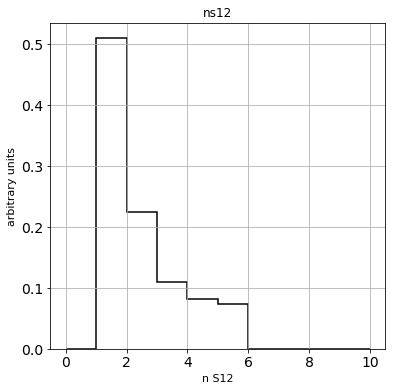

In [72]:
krf.ns12(dst_full, type='S1')

 0S2/tot  = 0.0 1S2/tot = 0.6252593389071802 2S2/tot = 0.2748613503074825


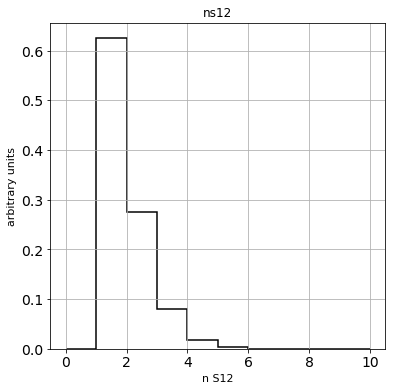

In [73]:
krf.ns12(dst_full, type='S2')

In [74]:
mu, var, s2r = krf.ns2_stats(dst_full)
krf.print_ns12_stats(mu, var, s2r)

ns12: mean =  1.50 std =  0.74
ns12 : fraction
0:  0.00
1:  0.63
2:  0.27
3:  0.08


In [75]:
monitor_vars['fraction_s2'] = s2r[1]

## Select events with only 1 s1 and 1 s2

In [76]:
dst1s1 = dst_full[dst_full.nS1==1]
dst    = dst1s1[dst1s1.nS2==1]

In [77]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 796187: selection eff = 0.3447835800309799 


In [78]:
s1d = krf.s1_means_and_vars(dst)
s2d = krf.s2_means_and_vars(dst)

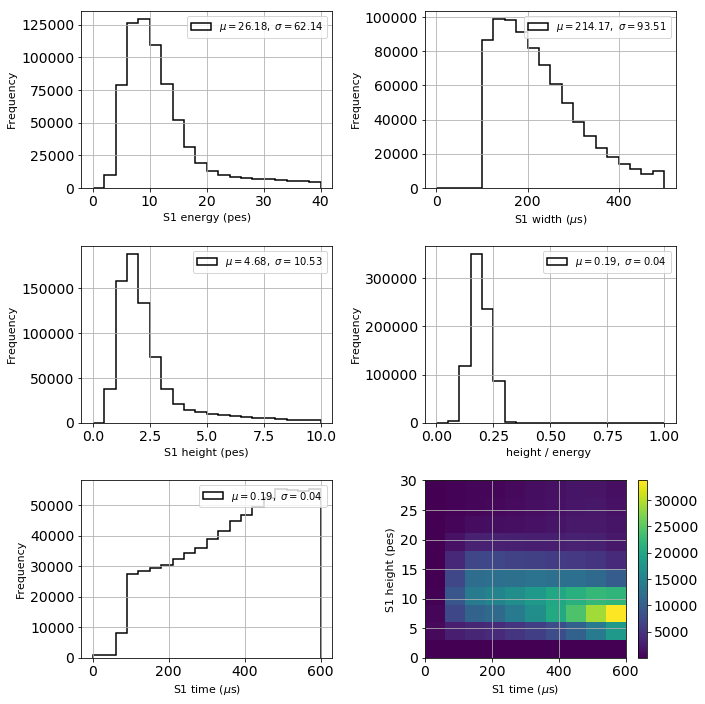

In [79]:
krf.plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

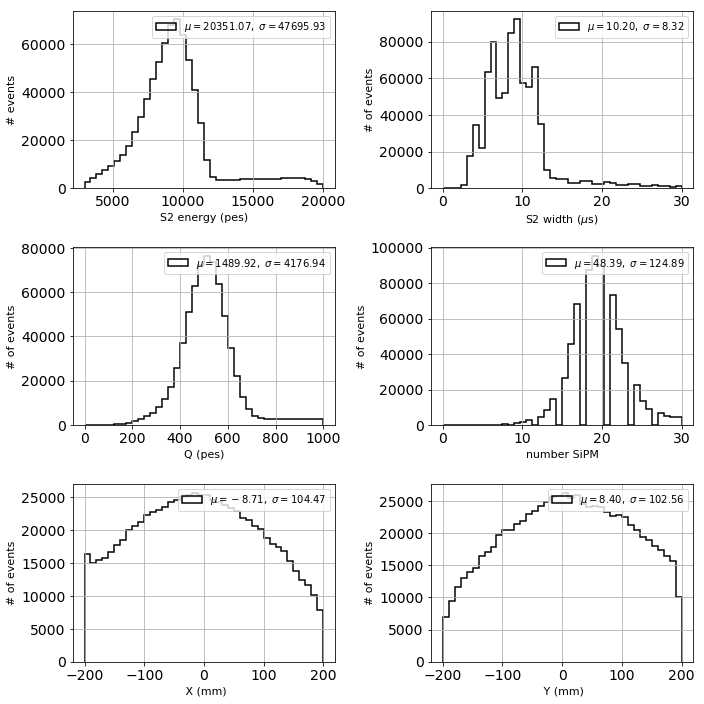

In [80]:
krf.plot_s2histos(dst, s2d, bins=40, emin=3000, emax=20000, figsize=(10,10))

### Ranges and Binning

In [81]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 12.5e3),
                                                              S1range = (   2,   25),
                                                              Qrange  = ( 100, 800),
                                                              Znbins        =   10,
                                                              XYnbins       =   60,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

### Fiducial definition

In [82]:
dst_sel_Q   =  dst[in_range(dst.S2q, *krRanges.Q)]
dst_sel_S2   = dst_sel_Q[in_range(dst_sel_Q.S2e, *krRanges.E)]
dst_sel_S1   = dst_sel_S2[in_range(dst_sel_S2.S1e, *krRanges.S1)]

n_S2       = len(dst_sel_S2)
n_S1       = len(dst_sel_S1)

eff_S2   = n_S2 / n_full 
eff_S1   = n_S1 / n_full

print(f" nS2 : {n_S2}: eff_S2 = {eff_S2} ")
print(f" nS1 : {n_S1}: eff_S1 = {eff_S1} ")

 nS2 : 649904: eff_S2 = 0.8162705495065857 
 nS1 : 620598: eff_S1 = 0.7794626136824641 


In [83]:
dst1        = dst_sel_S1[in_range(dst_sel_S1.X, *krRanges.XY)]
dstc        = dst1     [in_range(dst1.Y, *krRanges.XY)] 
n_XY       = len(dstc)
eff_XY   = n_XY / n_full
print(f" nXY : {n_XY}: eff_XY = {eff_XY} ")

 nXY : 616674: eff_XY = 0.7745341232650118 


In [84]:
w = interactive(energy_spectrum_rz_cut, ebins=krNBins.E, eRanges=krRanges.E, kdst=fixed(dstc), rmax=(0, 200, 10), zmin=(0,600), zinterval=(0,600))
display(w)

interactive(children=(IntSlider(value=200, description='rmax', max=200, step=10), IntSlider(value=0, description='zmin', max=600), IntSlider(value=600, description='zinterval', max=600), Output()), _dom_classes=('widget-interact',))

### Fiducial volumes

In [85]:
kdst= fiducial_volumes(dstc,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)

 nfull : 602004: eff_full = 0.9762110937059126 
 nfid : 335019: eff_fid = 0.5432675935745629 
 ncore : 147612: eff_core = 0.2393679642728573 
 nhcore : 36980: eff_hcore = 0.05996685444821737 


### Event distributions

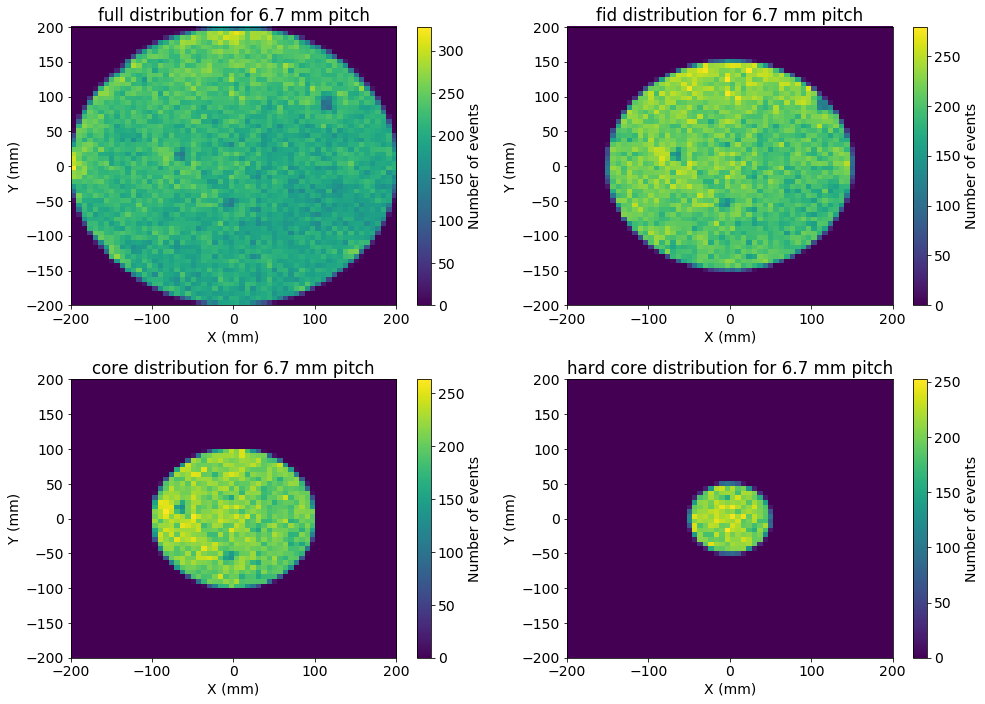

In [86]:
nEvt = krp.plot_xy_density(kdst, krBins)

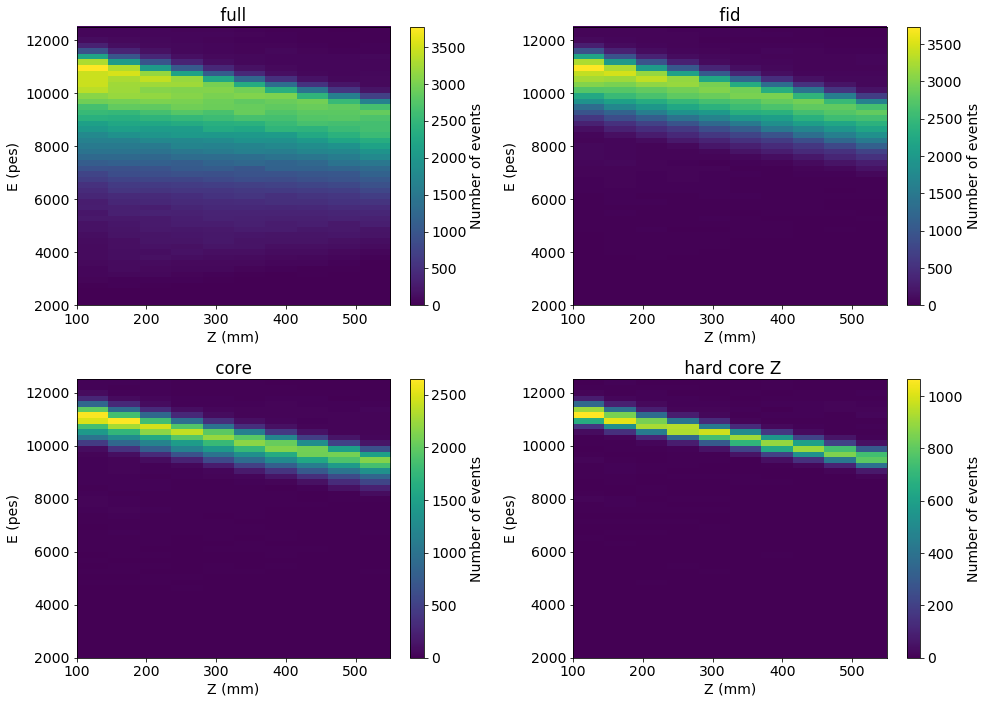

In [87]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

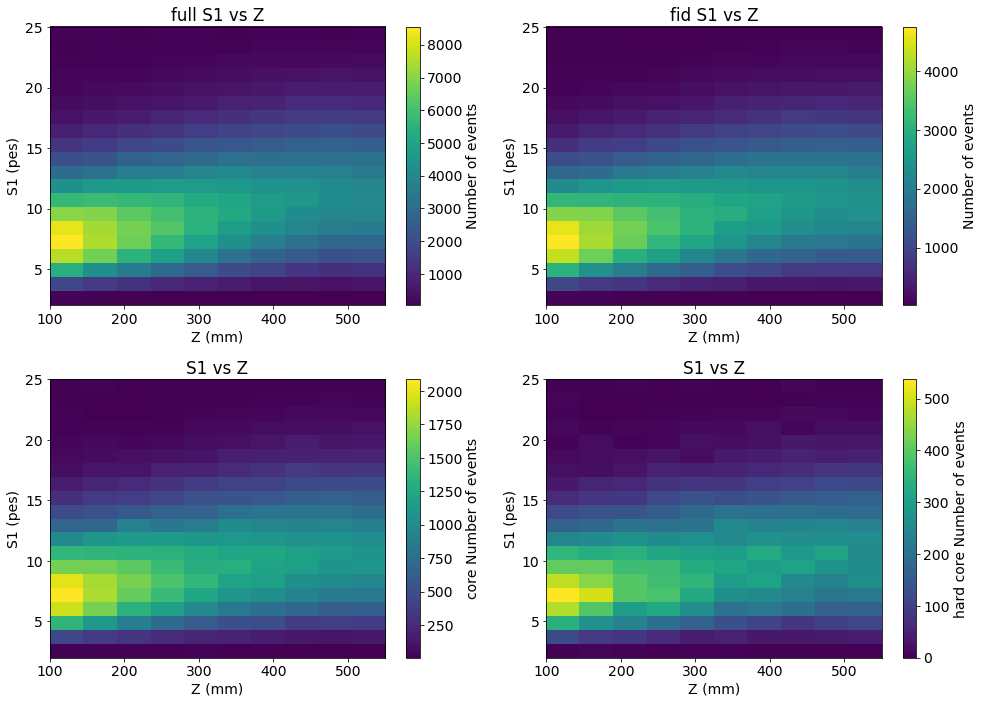

In [88]:
krp.plot_s1_vs_z(kdst, krBins, figsize=(14,10))

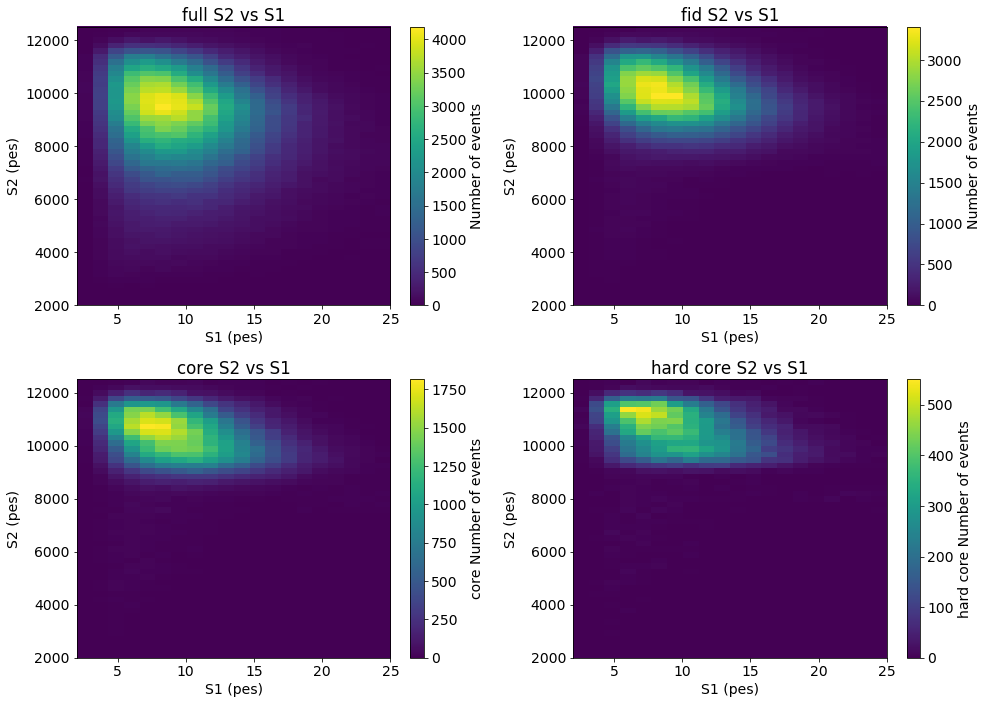

In [89]:
krp.plot_s2_vs_s1(kdst, krBins, figsize=(14,10))

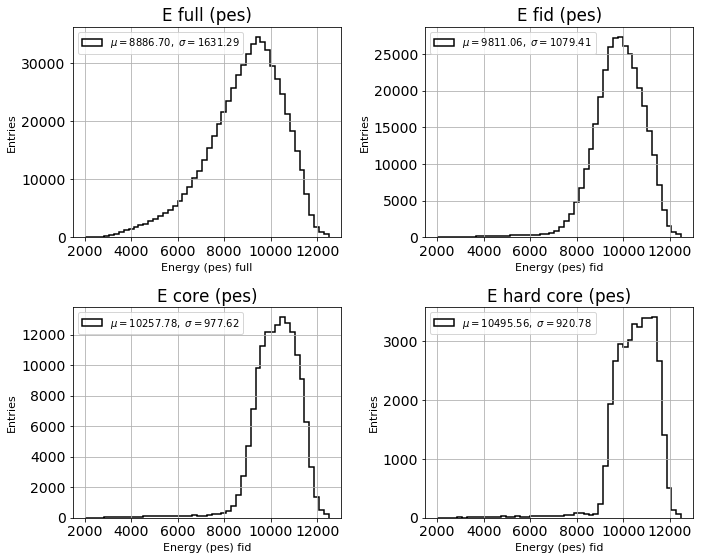

In [90]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names=('E_full', 'E_fid', 'E_core', 'E_hcore'),
                h1ds = (kdst.full.E, kdst.fid.E, kdst.core.E, kdst.hcore.E),
                bins = (krNBins.E, krNBins.E, krNBins.E, krNBins.E),
                ranges = (krRanges.E, krRanges.E, krRanges.E, krRanges.E),
                xlabels = ("Energy (pes) full", "Energy (pes) fid", "Energy (pes) fid", "Energy (pes) fid"),
                ylabels = ("Entries", "Entries", "Entries", "Entries"),
                titles = ("E full (pes)", "E fid (pes)", "E core (pes)", "E hard core (pes)"),
                legends = ("upper left", "upper left", "upper left", "upper left"),
                figsize =(10,8))

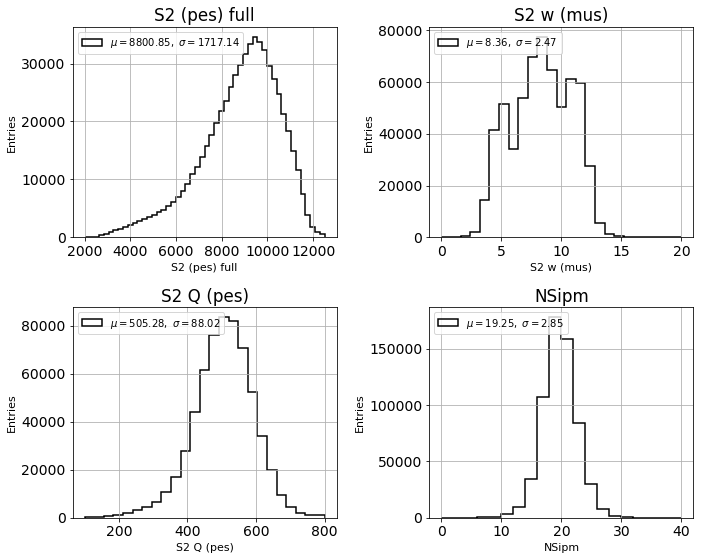

In [91]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names=('S2', 'S2w', 'Q', 'Nsipm'),
                h1ds = (dstc.S2e.values, dstc.S2w.values, dstc.S2q.values, dstc.Nsipm.values),
                bins = (krNBins.E, 25, krNBins.Q, 20),
                ranges = (krRanges.E, (0,20), krRanges.Q, (0,40)),
                xlabels = ("S2 (pes) full", "S2 w (mus)", "S2 Q (pes)", "NSipm"),
                ylabels = ("Entries", "Entries", "Entries", "Entries"),
                titles = ("S2 (pes) full", "S2 w (mus)", "S2 Q (pes)", "NSipm"),
                legends = ("upper left", "upper left", "upper left", "upper left"),
                figsize =(10,8))

In [92]:
monitor_vars['S2stats'] = stats

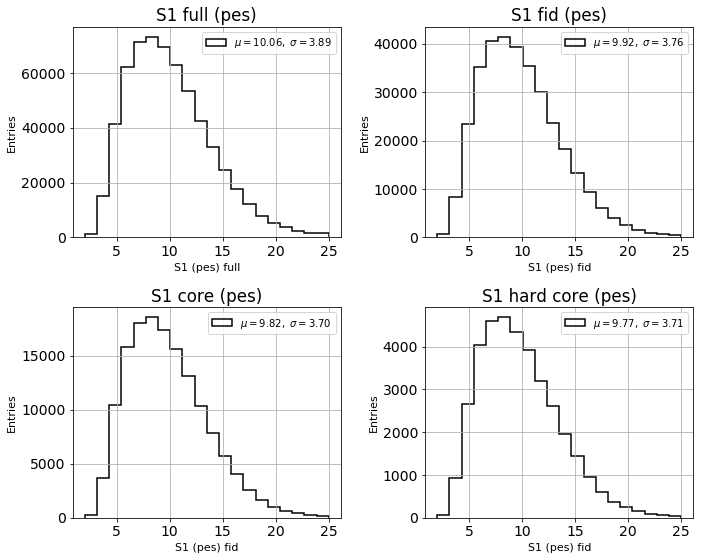

In [93]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names=('S1_full', 'S1_fid', 'S1_core', 'S1_hcore'),
                h1ds = (kdst.full.S1, kdst.fid.S1, kdst.core.S1, kdst.hcore.S1),
                bins = (krNBins.S1, krNBins.S1, krNBins.S1, krNBins.S1),
                ranges = (krRanges.S1, krRanges.S1, krRanges.S1, krRanges.S1),
                xlabels = ("S1 (pes) full", "S1 (pes) fid", "S1 (pes) fid", "S1 (pes) fid"),
                ylabels = ("Entries", "Entries", "Entries", "Entries"),
                titles = ("S1 full (pes)", "S1 fid (pes)", "S1 core (pes)", "S1 hard core (pes)"),
                legends = ("upper right", "upper right", "upper right", "upper right"),
                figsize =(10,8))

In [94]:
hr = divide_np_arrays(dst.S1h.values, dst.S1e.values)

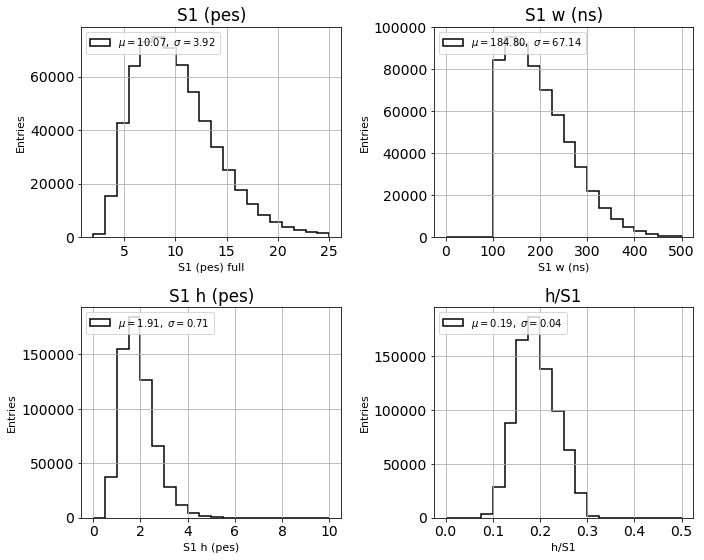

In [95]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names=('S1', 'S1w', 'S1h', 'hEr'),
                h1ds = (dstc.S1e.values, dstc.S1w.values, dstc.S1h.values, hr),
                bins = (krNBins.S1, 20, 20, 20),
                ranges = (krRanges.S1, (0,500), (0,10), (0,0.5)),
                xlabels = ("S1 (pes) full", "S1 w (ns)", "S1 h (pes)", "h/S1"),
                ylabels = ("Entries", "Entries", "Entries", "Entries"),
                titles = ("S1 (pes)", "S1 w (ns)", "S1 h (pes)", "h/S1"),
                legends = ("upper left", "upper left", "upper left", "upper left"),
                figsize =(10,8))

In [96]:
monitor_vars['S1stats'] = stats

### Write DST (merged and fiducial)

In [97]:
dstc.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [108]:
#del dst['index']

In [98]:
dstc.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)



In [99]:
# Workaround to re-establish the name of the table and its title
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

### Write monitor

In [100]:
def pd_monitor_vars(monitor_vars):
    c = []
    v = []
    for keys, values in monitor_vars['S1stats'].items():
        c.append(keys)
        v.append(values.value)
    for keys, values in monitor_vars['S2stats'].items():
        c.append(keys)
        v.append(values.value)
    c.append('fraction_s2')
    v.append(monitor_vars['fraction_s2'])

    m = {}
    for key, value in zip(c,v):
        m[key] = value
    mdf = pd.Series(m)
    return mdf

def write_monitor_vars(mdf, log_filename):
    mdf.to_hdf(log_filename,
              key     = "LOG"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)


In [101]:
mdf = pd_monitor_vars(monitor_vars)

In [102]:
mdf

Nsipm            19.254347
Q               505.284956
S1               10.070125
S1h               1.913686
S1w             184.803002
S2             8800.853548
S2w               8.360426
fraction_s2       0.625259
hEr               0.192834
dtype: float64

In [103]:
write_monitor_vars(mdf, log_filename)